# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.


## Introduction

Utilizing Sweet Lift Taxi's historical airport pickup order data from March - August 2018, we will work to train, tune, compare, and test several predictive models to help the company anticipate hourly demand.  The preprocessing and analysis of the data must meet the criteria set fourth above, with the RMSE for a final, tested predictive model falling below the threshold value of 48. Let's build!

In [2]:
!/opt/conda/envs/python3/bin/python -m pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.4 MB/s eta 0:00:00


In [3]:
# import pertinent libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import datetime as datetime
from time import time

import optuna

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

## Load and preprocess data

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

1. load data
2. index data chronologically by datetime stamp
3. check for missing values and duplicate datetimes

In [4]:
# load data with datetime index
df = pd.read_csv('/datasets/taxi.csv', index_col=[0],  parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# check info for datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# sort index and check for synced chronology
df = df.sort_index(axis='index')
print(df.index.is_monotonic)
print()
print(df.info())

True

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


In [7]:
# check for duplicate datetimes
df.index.duplicated().sum()

0

The data is indexed by date and timestamp in chronological order, and there are no repeating datetimes

## Analysis

### Resample

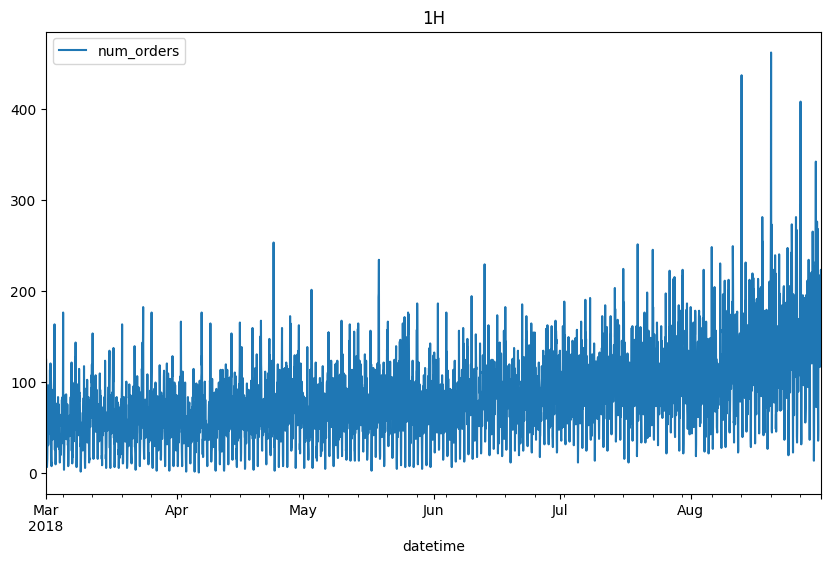

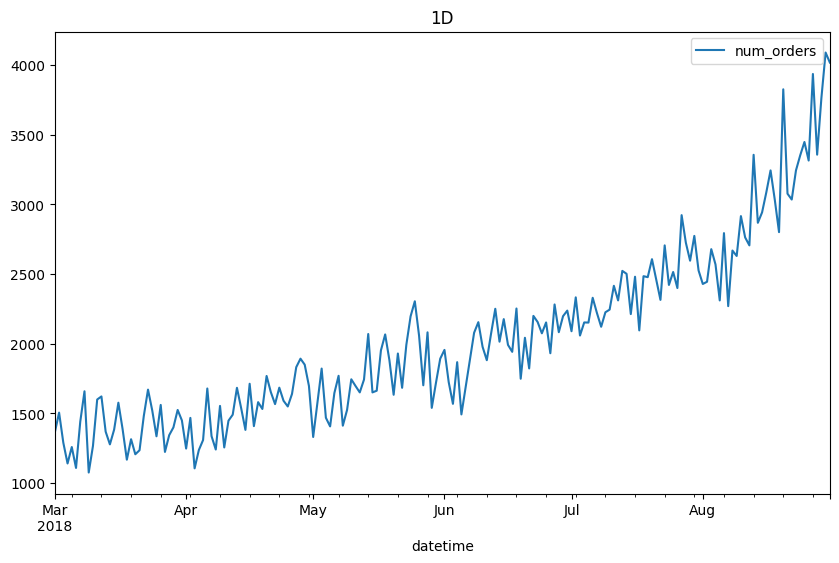

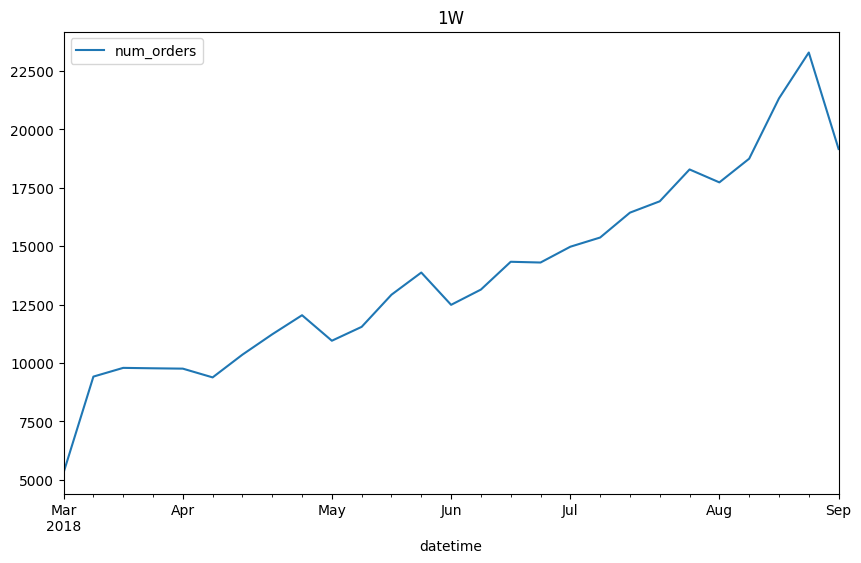

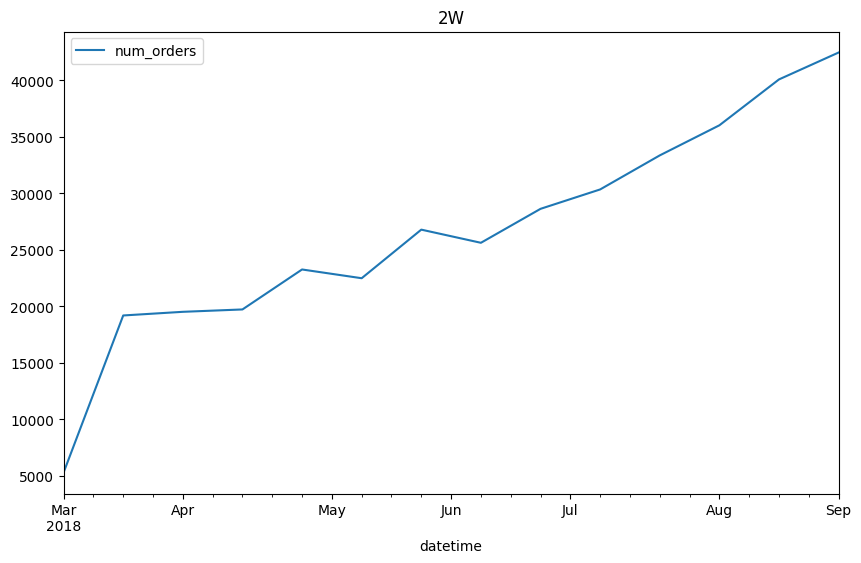

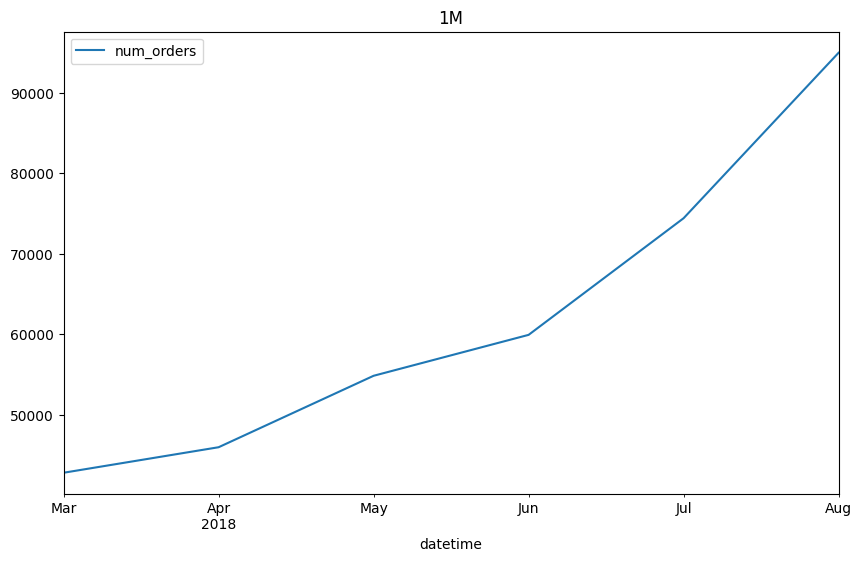

In [8]:
# visualize resampling on hour, day, week, bi-week, and month
samples = ['1H', '1D', '1W', '2W', '1M']
for sample in samples:
    samp = df.resample(sample).sum()
    samp.plot(figsize=(10, 6))
    plt.title(sample)
    print()

Looking through the various time series resampling groupings, a gradual increase in taxi airport orders from March to August becomes obvious.

### Moving average

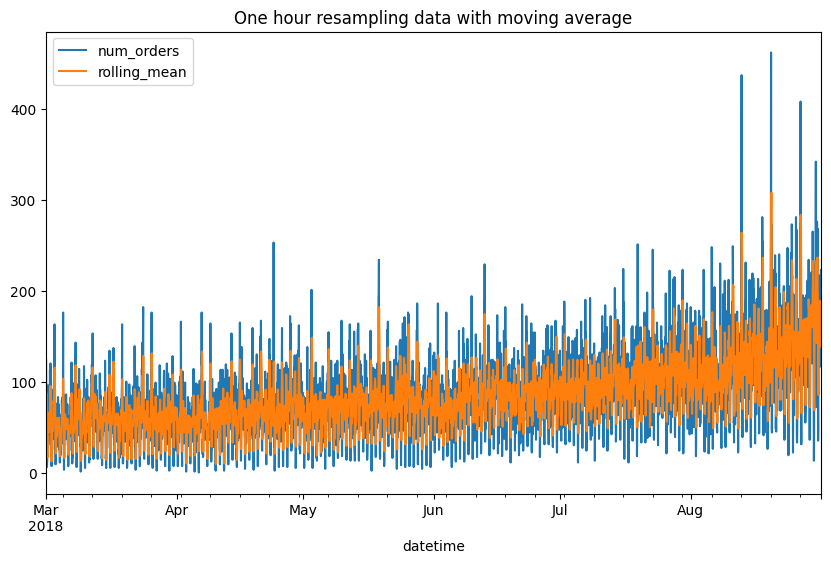

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,86.50
2018-03-01 04:00:00,43,66.25


In [9]:
# visualize the moving average over the 1 hour resampling
df_hr = df.resample('1H').sum()
df_hr['rolling_mean'] = df_hr.rolling(4).mean()

df_hr.plot(figsize=(10, 6))
plt.title('One hour resampling data with moving average')
plt.show()
display(df_hr.head())

### Trends and seasonality

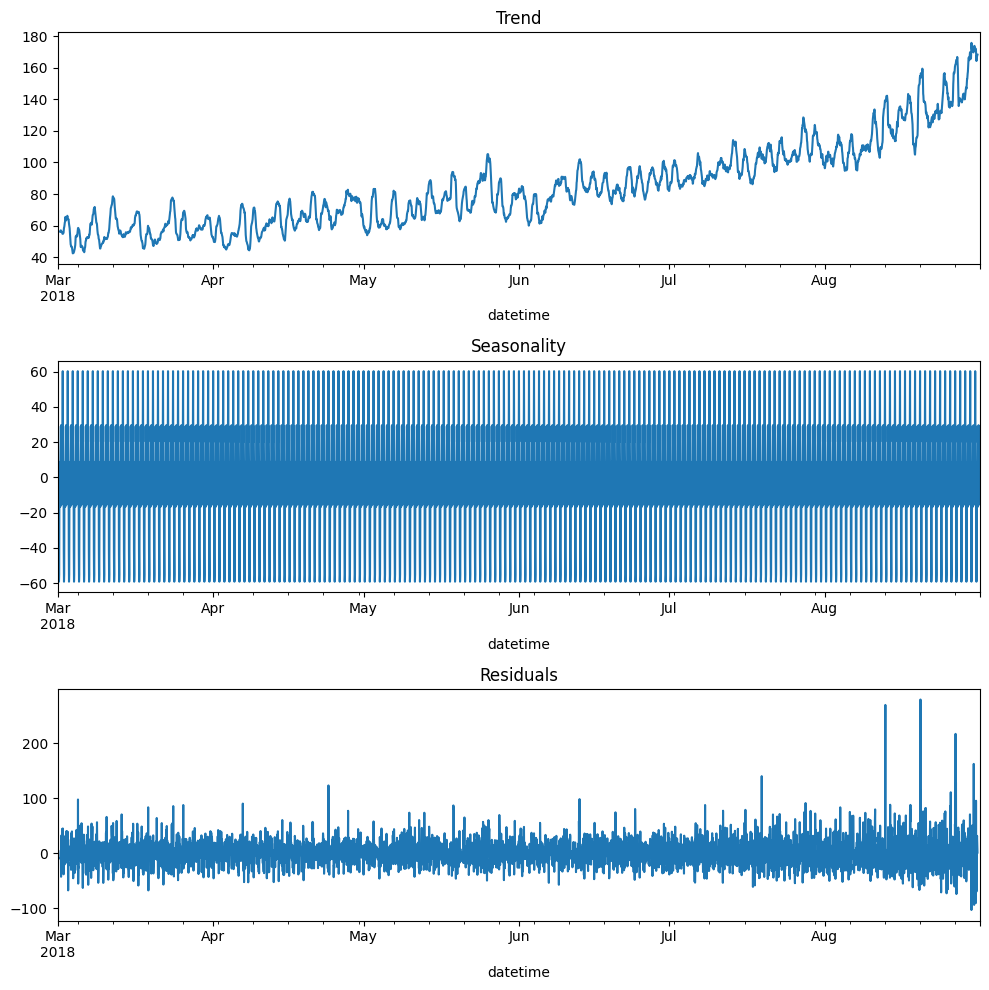

In [10]:
# Look into trends and seasonality
data_1h = df.resample('1H').sum()
decomposed = seasonal_decompose(data_1h)

# plot decomposed objects
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

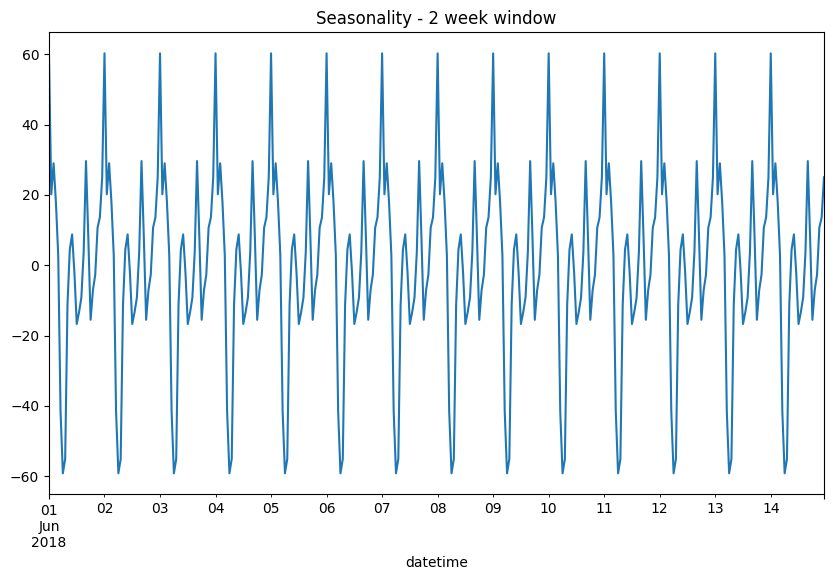

In [11]:
# a closer look at seasonality over a two week window in June
decomp_2w = decomposed.seasonal['2018-06-01':'2018-06-14']
plt.figure(figsize=(10, 6))
decomp_2w.plot(ax=plt.gca())
plt.title('Seasonality - 2 week window')
plt.show()

In [12]:
# compare the sum of trend + seasonality + residuals with corresponding slice of df
print(decomposed.trend[4:6] + decomposed.seasonal[4:6] + decomposed.resid[4:6])
print()
print(data_1h[4:6])

datetime
2018-03-01 04:00:00   NaN
2018-03-01 05:00:00   NaN
Freq: H, dtype: float64

                     num_orders
datetime                       
2018-03-01 04:00:00          43
2018-03-01 05:00:00           6


The values equate. The evaluation is correct. Taking a closer look at the data, a daily seasonality seems to appear.

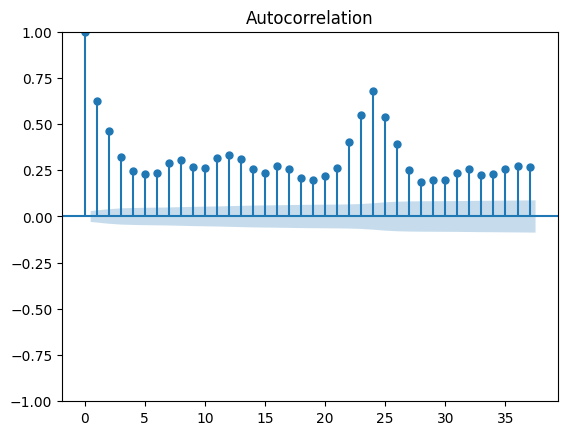

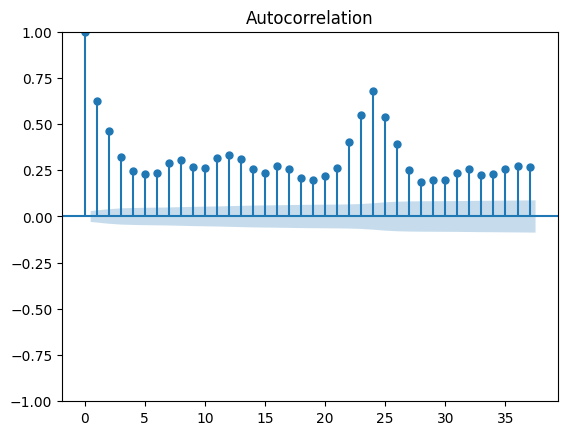

In [13]:
plot_acf(data_1h)

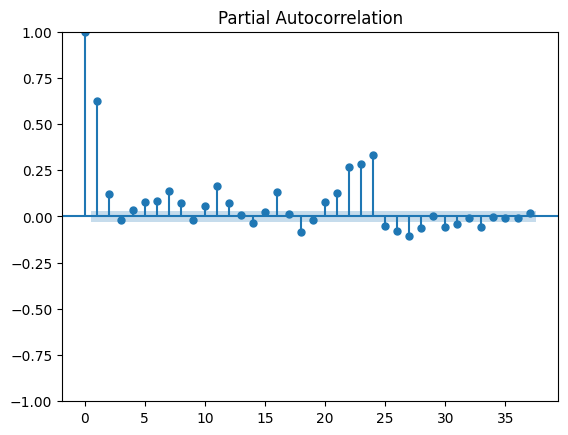

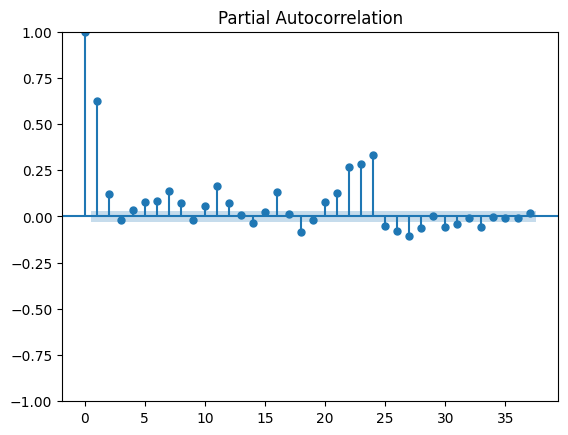

In [14]:
plot_pacf(data_1h)

Looking at the autocorrelation and partial autocorrelation, we see the highest correlations between lag 1 and lag 24. Autocorrelations are usually larger for lags at multiples of the seasonal frequency.  This is likely showing us some seasonality over a 24 hour window. We can confirm this with the 2 week seasonality graph above, as we see regular spikes toward the end of each 24 hour period. We can use this seasonality window as the maximum lag when preparing our features to train the models.

### Stationarity

In [15]:
adf, pval, usedlag, nobs, crit_vals, icbest = adfuller(data_1h['num_orders'].values)
print('ADF test statistic:', adf)
print('ADF p-values:', pval)
print('ADF number of lags used:', usedlag)
print('ADF number of observations:', nobs)
print('ADF critical values:', crit_vals)
print('ADF best information criterion:', icbest)

ADF test statistic: -3.068924289027954
ADF p-values: 0.028940051402613028
ADF number of lags used: 30
ADF number of observations: 4385
ADF critical values: {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}
ADF best information criterion: 41728.71357827463


The p-value is less than 0.05, thus we can proceed with the assumption that the data is stationary.

### Feature creation

In [16]:
data = df.resample('1H').sum()
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dow'] = data.index.dayofweek
    
    
    for lag in range(1, max_lag + 1):
        data['lag{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    data['std'] = data['num_orders'].shift().rolling(rolling_mean_size).std()
    
make_features(data, 24, 24)
data.head()

,num_orders,year,month,day,dow,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,rolling_mean,std
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Training

### Split data

In [17]:
# drop missing values from data
data = data.dropna()

# split data into 90% training and 10% test sequentially
train, test = train_test_split(data, shuffle=False, test_size=0.10)

In [18]:
#check the data split
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [19]:
# separate the features from the target for training and testing the models
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [20]:
tss = TimeSeriesSplit(n_splits=5)

### Linear regression model

In [21]:
lr = LinearRegression()

scores = cross_val_score(lr, features_train, target_train, cv=tss, scoring='neg_root_mean_squared_error')

scores.mean()

-27.038369525942578

### Random forest regressor

In [22]:
def rf_tune(trial):
    
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 11),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 9),
        'random_state': 12345
    }
    
    rf = RandomForestRegressor(**rf_params)
    scores = cross_val_score(rf, features_train, target_train, cv=tss, scoring='neg_root_mean_squared_error')
    
    return scores.mean()

rf_study = optuna.create_study(direction='maximize')
rf_study.optimize(rf_tune, n_trials=16)

[I 2024-08-31 00:14:12,419] A new study created in memory with name: no-name-67eb6120-f482-400a-9732-540d74a36ef5
[I 2024-08-31 00:14:12,963] Trial 0 finished with value: -29.52131190891162 and parameters: {'n_estimators': 15, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 0 with value: -29.52131190891162.
[I 2024-08-31 00:14:13,693] Trial 1 finished with value: -26.844625626949618 and parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 7}. Best is trial 1 with value: -26.844625626949618.
[I 2024-08-31 00:14:16,387] Trial 2 finished with value: -28.637930371517918 and parameters: {'n_estimators': 71, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 6}. Best is trial 1 with value: -26.844625626949618.
[I 2024-08-31 00:14:17,048] Trial 3 finished with value: -28.016951479119143 and parameters: {'n_estimators': 14, 'max_depth': 5, 'min_samples_leaf': 7, 'min_samples_split': 4}. Best is trial 1 with value:

In [23]:
print(rf_study.best_value)
print()
print('Best params:')
for key, value in rf_study.best_params.items():
    print(f'\t{key}: {value}')

-26.071675850813943

Best params:
	n_estimators: 55
	max_depth: 12
	min_samples_leaf: 1
	min_samples_split: 4


### LightGB

In [24]:
def lgb_tune(trial):
    
    lgb_params = {
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05),
        'n_estimators': trial.suggest_int('n_estimators', 10, 100, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.9, step=0.1),
        'max_depth': trial.suggest_int('max_depth', 2, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 11),
        'random_state': 12345
    }
    
    lgb = LGBMRegressor(**lgb_params)
    scores = cross_val_score(lgb, features_train, target_train, cv=tss, scoring='neg_root_mean_squared_error')
    
    return scores.mean()

lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_tune, n_trials=16)

[I 2024-08-31 00:15:00,117] A new study created in memory with name: no-name-338bb9e9-d4ef-47ac-84a9-04d9e0ba3541


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8


[I 2024-08-31 00:15:00,320] Trial 0 finished with value: -30.464133783595525 and parameters: {'learning_rate': 0.1, 'n_estimators': 13, 'subsample': 0.9, 'max_depth': 3, 'min_data_in_leaf': 8}. Best is trial 0 with value: -30.464133783595525.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11


[I 2024-08-31 00:15:00,717] Trial 1 finished with value: -28.729856582763876 and parameters: {'learning_rate': 0.1, 'n_estimators': 15, 'subsample': 0.7, 'max_depth': 5, 'min_data_in_leaf': 11}. Best is trial 1 with value: -28.729856582763876.


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-08-31 00:15:01,712] Trial 2 finished with value: -26.743065296390633 and parameters: {'learning_rate': 0.05, 'n_estimators': 47, 'subsample': 0.7, 'max_depth': 8, 'min_data_in_leaf': 10}. Best is trial 2 with value: -26.743065296390633.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-08-31 00:15:02,335] Trial 3 finished with value: -26.063467366022543 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 27, 'subsample': 0.6, 'max_depth': 11, 'min_data_in_leaf': 10}. Best is trial 3 with value: -26.063467366022543.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6


[I 2024-08-31 00:15:02,815] Trial 4 finished with value: -32.05842001261666 and parameters: {'learning_rate': 0.05, 'n_estimators': 14, 'subsample': 0.6, 'max_depth': 10, 'min_data_in_leaf': 6}. Best is trial 3 with value: -26.063467366022543.


[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-08-31 00:15:03,717] Trial 5 finished with value: -27.447253257784666 and parameters: {'learning_rate': 0.05, 'n_estimators': 38, 'subsample': 0.5, 'max_depth': 7, 'min_data_in_leaf': 10}. Best is trial 3 with value: -26.063467366022543.


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


[I 2024-08-31 00:15:05,520] Trial 6 finished with value: -25.740826087177947 and parameters: {'learning_rate': 0.05, 'n_estimators': 98, 'subsample': 0.8, 'max_depth': 9, 'min_data_in_leaf': 10}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9
[LightGBM] [Warning] min_data_in_leaf is set=9, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9


[I 2024-08-31 00:15:06,120] Trial 7 finished with value: -26.868528925971013 and parameters: {'learning_rate': 0.1, 'n_estimators': 23, 'subsample': 0.9, 'max_depth': 9, 'min_data_in_leaf': 9}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7
[LightGBM] [Warning] min_data_in_leaf is set=7, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=7


[I 2024-08-31 00:15:07,319] Trial 8 finished with value: -26.647656294294507 and parameters: {'learning_rate': 0.05, 'n_estimators': 51, 'subsample': 0.6, 'max_depth': 12, 'min_data_in_leaf': 7}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2024-08-31 00:15:07,616] Trial 9 finished with value: -27.73257428836714 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 15, 'subsample': 0.8, 'max_depth': 4, 'min_data_in_leaf': 4}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2024-08-31 00:15:09,118] Trial 10 finished with value: -26.22326252907242 and parameters: {'learning_rate': 0.2, 'n_estimators': 96, 'subsample': 0.8, 'max_depth': 6, 'min_data_in_leaf': 1}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-08-31 00:15:10,718] Trial 11 finished with value: -25.958518619866084 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 84, 'subsample': 0.5, 'max_depth': 12, 'min_data_in_leaf': 5}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4


[I 2024-08-31 00:15:12,429] Trial 12 finished with value: -26.326209321371813 and parameters: {'learning_rate': 0.2, 'n_estimators': 96, 'subsample': 0.5, 'max_depth': 12, 'min_data_in_leaf': 4}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


[I 2024-08-31 00:15:13,721] Trial 13 finished with value: -25.907981187925053 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 65, 'subsample': 0.8, 'max_depth': 10, 'min_data_in_leaf': 5}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2


[I 2024-08-31 00:15:15,224] Trial 14 finished with value: -25.788570509021593 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 66, 'subsample': 0.8, 'max_depth': 9, 'min_data_in_leaf': 2}. Best is trial 6 with value: -25.740826087177947.


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


[I 2024-08-31 00:15:16,528] Trial 15 finished with value: -25.91208710642706 and parameters: {'learning_rate': 0.1, 'n_estimators': 64, 'subsample': 0.8, 'max_depth': 8, 'min_data_in_leaf': 1}. Best is trial 6 with value: -25.740826087177947.


In [25]:
print(lgb_study.best_value)
print()
print('Best params:')
for key, value in lgb_study.best_params.items():
    print(f'\t{key}: {value}')

-25.740826087177947

Best params:
	learning_rate: 0.05
	n_estimators: 98
	subsample: 0.8
	max_depth: 9
	min_data_in_leaf: 10


### CatBoost

In [26]:
def cb_tune(trial):
    
    cb_params = {
                 'silent': True,
                 'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05),
                 'n_estimators': trial.suggest_int('n_estimators', 10, 100, log=True),
                 'subsample': trial.suggest_float('subsample', 0.5, 0.9, step=0.1),
                 'max_depth': trial.suggest_int('max_depth', 2, 12),
                 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 11),
                 'random_state': 12345
                 }
    
    cb = CatBoostRegressor(**cb_params)
    scores = cross_val_score(cb, features_train, target_train, cv=tss, scoring='neg_root_mean_squared_error')
    
    return scores.mean()

cb_study = optuna.create_study(direction='maximize')
cb_study.optimize(cb_tune, n_trials=16)

[I 2024-08-31 00:15:16,620] A new study created in memory with name: no-name-e26ab881-9357-434b-ade7-21aa334b3e32
[I 2024-08-31 00:15:22,875] Trial 0 finished with value: -36.52155692463182 and parameters: {'learning_rate': 0.05, 'n_estimators': 10, 'subsample': 0.5, 'max_depth': 12, 'min_data_in_leaf': 1}. Best is trial 0 with value: -36.52155692463182.
[I 2024-08-31 00:15:25,616] Trial 1 finished with value: -27.911473399063006 and parameters: {'learning_rate': 0.2, 'n_estimators': 15, 'subsample': 0.7, 'max_depth': 10, 'min_data_in_leaf': 11}. Best is trial 1 with value: -27.911473399063006.
[I 2024-08-31 00:15:26,481] Trial 2 finished with value: -26.899190276664605 and parameters: {'learning_rate': 0.15000000000000002, 'n_estimators': 24, 'subsample': 0.8, 'max_depth': 6, 'min_data_in_leaf': 7}. Best is trial 2 with value: -26.899190276664605.
[I 2024-08-31 00:15:30,564] Trial 3 finished with value: -28.604097531310305 and parameters: {'learning_rate': 0.1, 'n_estimators': 24, 'su

In [27]:
print(cb_study.best_value)
print()
print('Best params:')
for key, value in cb_study.best_params.items():
    print(f'\t{key}: {value}')

-25.536586299392265

Best params:
	learning_rate: 0.2
	n_estimators: 98
	subsample: 0.9
	max_depth: 8
	min_data_in_leaf: 4


After training and tuning our models (linear regression, random forest, lightGB, and Catboost), on the feature enhanced data, the catboost model showed the best rmse at 25.54.  All the models ranged within 1-2 points above this score.  Next, lets test these models using the cross-validated hyperparameters for each.

## Testing

### Linear Regression

In [28]:
lr.fit(features_train, target_train)
y_pred_lr = lr.predict(features_test)
lr_rmse = np.sqrt(mean_squared_error(target_test, y_pred_lr))

print('Linear regression final RMSE: {:.5}'.format(lr_rmse))

Linear regression final RMSE: 45.563


### Random forest

In [32]:
rf_opt = RandomForestRegressor(n_estimators=55, 
                               max_depth=12, 
                               min_samples_leaf=1, 
                               min_samples_split=4, 
                               random_state=12345)
rf_opt.fit(features_train, target_train)
y_pred_rf = rf_opt.predict(features_test)
rf_opt_rmse = np.sqrt(mean_squared_error(target_test, y_pred_rf))

print('Random forest regression final RMSE: {:.5}'.format(rf_opt_rmse))

Random forest regression final RMSE: 44.265


### LightGB

In [33]:
lgb_opt = LGBMRegressor(learning_rate=0.05, 
                        n_estimators=98, 
                        subsample=0.8, 
                        max_depth=9, 
                        min_data_in_leaf=10)
lgb_opt.fit(features_train, target_train)
y_pred_lgb = lgb_opt.predict(features_test)
lgb_opt_rmse = np.sqrt(mean_squared_error(target_test, y_pred_lgb))

print('LightGB regressor final RMSE: {:.5}'.format(lgb_opt_rmse))

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
LightGB regressor final RMSE: 41.497


### Catboost

In [34]:
cb_opt = CatBoostRegressor(learning_rate=0.2, 
                           n_estimators=98, 
                           subsample=0.9, 
                           max_depth=8, 
                           min_data_in_leaf=4)
cb_opt.fit(features_train, target_train)
y_pred_cb = cb_opt.predict(features_test)
cb_opt_rmse = np.sqrt(mean_squared_error(target_test, y_pred_cb))

print('Catboost regressor final RMSE: {:.5}'.format(cb_opt_rmse))

0:	learn: 35.1685365	total: 20ms	remaining: 1.94s
1:	learn: 32.5856069	total: 33.1ms	remaining: 1.59s
2:	learn: 30.5515269	total: 46.1ms	remaining: 1.46s
3:	learn: 28.9021018	total: 58.4ms	remaining: 1.37s
4:	learn: 27.6871460	total: 70.6ms	remaining: 1.31s
5:	learn: 26.7317690	total: 83.5ms	remaining: 1.28s
6:	learn: 25.8477425	total: 95.8ms	remaining: 1.25s
7:	learn: 25.2732886	total: 108ms	remaining: 1.22s
8:	learn: 24.6701715	total: 121ms	remaining: 1.19s
9:	learn: 24.3028638	total: 134ms	remaining: 1.18s
10:	learn: 23.8503473	total: 147ms	remaining: 1.16s
11:	learn: 23.5321774	total: 159ms	remaining: 1.14s
12:	learn: 23.1353786	total: 172ms	remaining: 1.12s
13:	learn: 22.8437609	total: 184ms	remaining: 1.1s
14:	learn: 22.7671543	total: 198ms	remaining: 1.1s
15:	learn: 22.5398274	total: 210ms	remaining: 1.08s
16:	learn: 22.2755534	total: 223ms	remaining: 1.06s
17:	learn: 22.0205189	total: 236ms	remaining: 1.05s
18:	learn: 21.8857945	total: 247ms	remaining: 1.03s
19:	learn: 21.70446

## Conclusion

To begin, we cleaned, verified the stationarity, and added features of significance to our data. We then built, trained, and tested each of our time series forcasting models on our modified Sweet Lift taxi data from the six month period between 2018/03/02 - 2018/08/31.  

All four of our model's RMSE scores fell below the threshold RMSE of 48, with our worst scoring model being the linear regression model, still coming in alomst 2.5 points below the RMSE threshold. The best performing model when applied to the feature fitted, sequential time series data in testing was the LightGB model, with a final RMSE of 41.50. Catboost followed behind in second place with an RMSE of 42.39, followed by the random forest model. These scores could perhaps improve with full yearly data, futher extrapolated hyperparameter tuning and more feature creations.

My recommendation for predicting Sweet Lift taxi's hourly airport ride orders would be the LightGB model based on it's speed and accuracy when dealing with this particular sequential, hourly time series data. The model will allow the company to better anticipate hourly customer demand thereby giving them the insight to efficiently adjust the staffing and proximity of drivers. Ideally this will lead to reduced pickup wait times, boosting revenue, and improving customer satisfaction.